# Kaggle Competition - Digit Recognizer

The code in this notebook was created to participate in the **Digit Recognizer** competition on kaggle.com (https://www.kaggle.com/competitions/digit-recognizer). To be honest, the notebook just contains as much code as required to get first results. Especially the part related to model building is reduced to a minimum. However, feel free to use this code as starting point for your own attempt to recognize the digits.

## Data

*Copy-pasted from `https://www.kaggle.com/c/digit-recognizer/data?select=test.csv`.*

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

* Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

* The training data set has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

* Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).
    * For example, pixel31 indicates the pixel that is in the fourth column from the left.
    
* The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

## Start of the project

### Importing modules and datasets:

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, conf

Training and test dataset:

In [4]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

Separate the labels from the pixels data in the training dataset:

In [5]:
y_train = train_data["label"]
train_data.drop(columns = ["label"], axis = 1, inplace = True)

In [6]:
X_train = train_data

In [7]:
del train_data

Rename test dataset as only features are included:

In [8]:
X_test = test_data

In [9]:
del test_data

Inspect the shapes of both datasets:

In [10]:
print(y_train.shape)
print(X_train.shape)

(42000,)
(42000, 784)


In [11]:
print(X_test.shape)

(28000, 784)


## Exploratory Data Analysis:

### Labels:

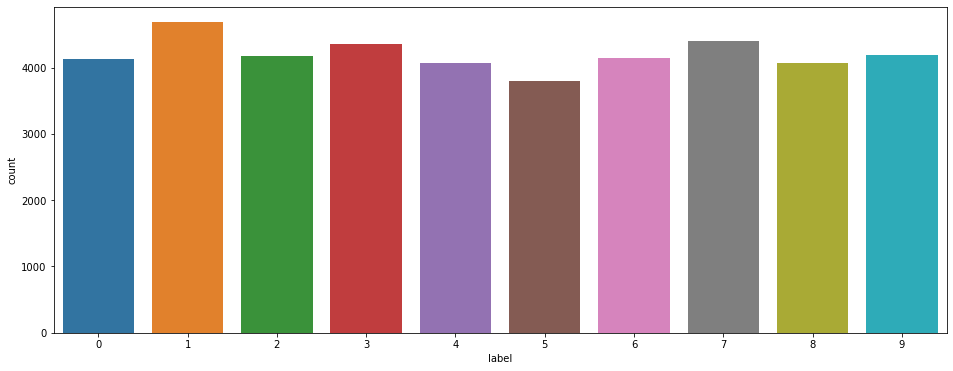

In [12]:
fig, ax = plt.subplots(figsize = (16, 6))
sns.countplot(x = y_train, ax = ax)
plt.show()

In [14]:
y_train.value_counts(normalize = True, sort = False) * 100

0     9.838095
1    11.152381
2     9.945238
3    10.359524
4     9.695238
5     9.035714
6     9.850000
7    10.478571
8     9.673810
9     9.971429
Name: label, dtype: float64

As indicated by the value counts all labels are balanced (represented by almost equal proportions).

### Handle missing values

In [15]:
print(y_train.isna().sum())

0


In [16]:
print(sum(X_train.isna().sum()))
print(sum(X_test.isna().sum()))

0
0


Luckily, the datasets contain no missing values. Hence, no further steps required.

### Rescale data:

The features are scaled to a range between 0 and 1 instead of 0 and 255. This scaling is applied to ensure numeric stability:

In [17]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Visualize some digits:

To get a better understanding of the dataset, some digits are visualized:

In [18]:
first_digit = X_train.iloc[0, :]
first_digit_shaped = np.array(first_digit).reshape(28, 28)

In [19]:
last_digit = X_train.iloc[-1, :]
last_digit_shaped = np.array(last_digit).reshape(28, 28)

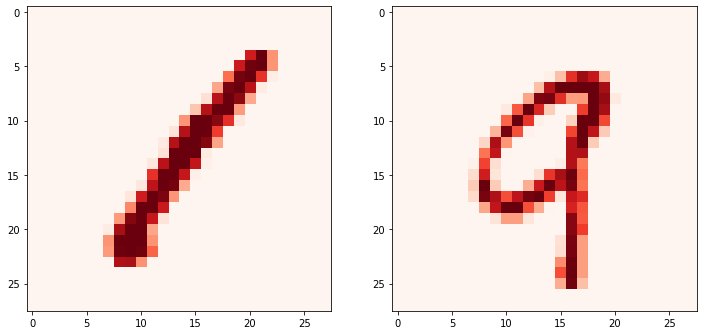

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
axes[0].imshow(first_digit_shaped, cmap = "Reds")
axes[1].imshow(last_digit_shaped, cmap = "Reds")
plt.show()

Digit in left plot looks a '1', while the right plot shows probably a '9'. Lets check by examine the labels:

In [21]:
print(f'Left plot shows a: {y_train.iloc[0]}')
print(f'Right plot shows a: {y_train.iloc[-1]}')

Left plot shows a: 1
Right plot shows a: 9


## Data Prepration and Modelling

### Evaluation strategy:

The model performance are evaluated by using the accuracy score. To obtain robust results, a stratified cross validation (to maintain the proportions of labels) is applied. 

In [23]:
strat_cv_folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 69)

In [24]:
def cv_model_accuracy(model, X = X_train, y = y_train):
    cv_acc = cross_val_score(model, X, y, cv = strat_cv_folds, scoring = "accuracy")
    return cv_acc

### K-Nearest Neighbors

The first model is a K-Nearest Neighbors classifier with the default number of neighbors (5):

In [25]:
k_neighs = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)

In [26]:
cv_model_accuracy(k_neighs).mean()

0.9666428571428571

Quite high accuracy for a simple model. Could be a sign of overfitting. 

### Support Vector Classifier

The next model is "naked" support vector classifier:

In [32]:
sv_classifier = SVC(random_state = 69, max_iter = 100000)

In [33]:
cv_model_accuracy(sv_classifier).mean()

0.9757380952380952

See comments on the K-Neighbors Classifier.

### Decision Tree Classifier

After using linear models, tree-based models are examined. The first one is a simple Decision Tree Classifier: 

In [34]:
dec_tree = DecisionTreeClassifier(random_state = 69)

In [35]:
cv_model_accuracy(dec_tree).mean()

0.8533571428571429

The results indicates that this Decision Tree model could be less influenced by overfitting (relative to the first two models). 

### Random Forest Classifier

Following the Decision Tree, a Random Forest Classifier is implemented:

In [36]:
rnd_forest = RandomForestClassifier(random_state = 69, n_jobs = -1)

In [37]:
cv_rnd_forest = cv_model_accuracy(rnd_forest)

In [38]:
cv_rnd_forest.mean()

0.9636428571428572

See comments on the K-Neighbors Classifer.

Since the Decision Tree Classifier's results reflect the lowest probability of overfitting, I will the model to make predictions based on the test dataset. 

In [39]:
dec_tree_fitted = DecisionTreeClassifier(random_state = 69).fit(X_train, y_train)

In [40]:
dec_tree_pred = dec_tree_fitted.predict(X_test)

*Additionally, predictions are generated using the Random Forest Classifier (for comparison):*

In [44]:
rnd_forest_fitted = RandomForestClassifier(random_state = 69, n_jobs = -1).fit(X_train, y_train)

In [45]:
rnd_forest_pred = rnd_forest_fitted.predict(X_test)

## Visualize digits contained in the test dataset

The first nine digits are visualized:

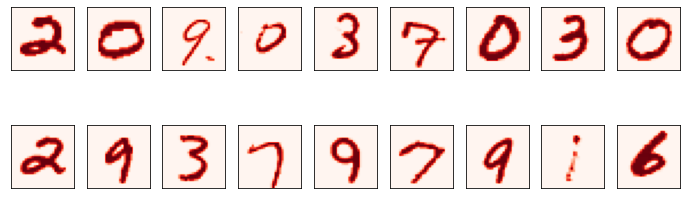

In [76]:
fig, axes = plt.subplots(nrows = 2, ncols = 9, figsize = (12, 4), sharey = True)
i = 0
row = 0

for col in range(9):
    digits_pixels = np.array(X_test.iloc[i, :]).reshape(28, 28)
    axes[row][col].imshow(digits_pixels, cmap = "Reds")
    axes[row][col].get_xaxis().set_visible(False)
    axes[row][col].get_yaxis().set_visible(False)
    i += 1
    
i = 1
row = 1

for col in range(9):
    digits_pixels = np.array(X_test.iloc[-i, :]).reshape(28, 28)
    axes[row][col].imshow(digits_pixels, cmap = "Reds")
    axes[row][col].get_xaxis().set_visible(False)
    axes[row][col].get_yaxis().set_visible(False)
    i += 1

plt.show()

In [73]:
# Alternative viz:

#fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (4, 4), sharey = True, sharex = True)
#i = 0

#for col in range(3):
#    for row in range(3):
#        digits_pixels = np.array(X_test.iloc[i, :]).reshape(28, 28)
#        axes[row][col].imshow(digits_pixels, cmap = "Reds")
#        axes[row][col].get_xaxis().set_visible(False)
#        axes[row][col].get_yaxis().set_visible(False)
#        i += 1
#plt.show()

Store the labels manually in a list:

In [71]:
first_test_digits_labels = [2, 0, 9, 0, 3, 7, 0, 3, 0]

In [77]:
# I know: some of the digits are not really readable. However, I assume to know the correct answer.

last_test_digits_labels = [2, 9, 3, 1, 9, 7, 9, 1, 6]

Next, the digits are compared with the predictions:

In [87]:
print(dec_tree_pred[0:9])
print(dec_tree_pred[:-10:-1])

[2 0 9 9 9 9 0 3 0]
[2 9 3 7 9 7 0 1 8]


In [93]:
dec_tree_first_digits_correct = dec_tree_pred[0:9] == first_test_digits_labels
dec_tree_last_digits_correct = dec_tree_pred[:-10:-1] == last_test_digits_labels

In [95]:
print(f'The decision tree got {dec_tree_first_digits_correct.sum()} out of the first 9 digits correct')
print(f'The decision tree got {dec_tree_last_digits_correct.sum()} out of the last 9 digits correct')

The decision tree got 6 out of the first 9 digits correct
The decision tree got 6 out of the last 9 digits correct


In [88]:
print(rnd_forest_pred[0:9])
print(rnd_forest_pred[:-10:-1])

[2 0 9 9 3 7 0 3 0]
[2 9 3 7 9 7 9 1 6]


In [96]:
rnd_forest_first_digits_correct = rnd_forest_pred[0:9] == first_test_digits_labels
rnd_forest_last_digits_correct = rnd_forest_pred[:-10:-1] == last_test_digits_labels

In [97]:
print(f'The random forest got {rnd_forest_first_digits_correct.sum()} out of the first 9 digits correct')
print(f'The random forest got {rnd_forest_last_digits_correct.sum()} out of the last 9 digits correct')

The random forest got 8 out of the first 9 digits correct
The random forest got 8 out of the last 9 digits correct


It seems that the Random Forest Classifier is the better choice for predicting (recognizing) the digits in this particular dataset. Hence, I will predict the digits using the Random Forest and submit the results. 

## Prepare submission:

In [98]:
sample_sub = pd.read_csv("sample_submission.csv", usecols = [0])

In [99]:
sample_sub["Label"] = rnd_forest_pred

In [100]:
sample_sub.to_csv("digit_recognizer_submission.csv", index = False)